In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from zipfile import ZipFile
import shutil
import os
import tqdm
import scipy
import glob
import matplotlib.pyplot as plt
import scipy.spatial
import copy
import pydegensac
import gc
import collections
import operator

import logging
tf.get_logger().setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

tf.config.set_visible_devices([], 'GPU')

import sys
sys.path.append('../')

import config
import generator
import models
import serve

In [2]:
train_df = pd.read_csv('../input/train.csv')

In [3]:
imported = tf.saved_model.load('../output/served_models/model')

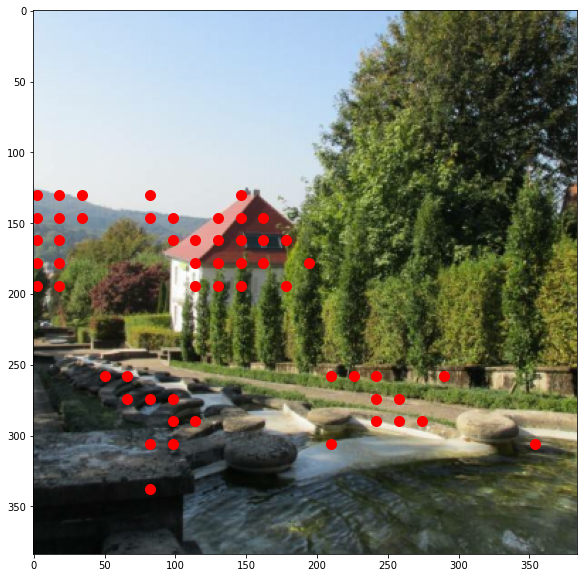

In [4]:
image = imported.extract_image(
        path = '../input/train',
        image_id=train_df.id[52],
        dim=384, 
        central_crop=True, 
        crop_ratio=(0.7, 1.0))

global_descriptor, (local_descriptor, points) = imported.extract_global_and_local_descriptor(
    image=image,
    l2_norm=True,
    attention_threshold=175.0,
    nms_max_feature_num=1000,
    nms_iou_threshold=1.0)


plt.figure(figsize=(10, 10))
plt.imshow(image[0])

plt.scatter(points[:, 1], points[:, 0], s=100, c='red')

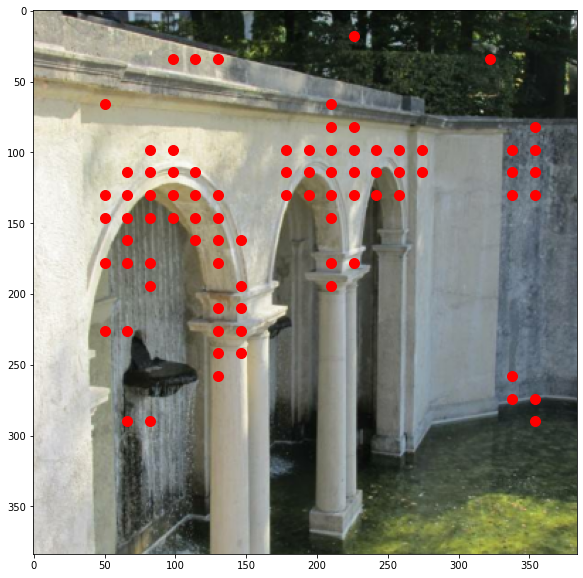

In [5]:
image = imported.extract_image(
        path = '../input/train',
        image_id=train_df.id[51],
        dim=384, 
        central_crop=True, 
        crop_ratio=(0.7, 1.0))

global_descriptor, (local_descriptor, points) = imported.extract_global_and_local_descriptor(
    image=image,
    l2_norm=True,
    attention_threshold=175.0,
    nms_max_feature_num=1000,
    nms_iou_threshold=1.0)



plt.figure(figsize=(10, 10))
plt.imshow(image[0])

plt.scatter(points[:, 1], points[:, 0], s=100, c='red')

In [11]:

def _extract_global_descriptors(model, path, image_ids):
    
    embeddings = tf.TensorArray(tf.float32, size=0, dynamic_size=True)

    for i, image_id in enumerate(tqdm.tqdm(image_ids)):
        
        image = model.extract_image(
            path=path,
            image_id=image_id,
            dim=384, 
            central_crop=True, 
            crop_ratio=(0.7, 1.0))
        
        global_descriptor = model.extract_global_descriptor(image=image, l2_norm=True)
        
        embeddings = embeddings.write(i, global_descriptor)
        
    return embeddings.stack().numpy()

def compute_global_scores(model, 
                          train_ids, 
                          train_labels,
                          test_ids,
                          num_to_rerank):
    
    # extract global descriptors for train and test data
    train_descriptors = _extract_global_descriptors(model, '../input/train', train_ids)
    test_descriptors = _extract_global_descriptors(model, '../input/train', test_ids)
    # a mapping from path->label
    mapping = dict(zip(train_ids, train_labels))
    
    # initialize accumulator
    train_ids_labels_scores = [None] * test_descriptors.shape[0]
    
    for i, test_descriptor in enumerate(tqdm.tqdm(test_descriptors)):
        
        # compute distances between test_descriptor[i] and train_descriptors
        distances = scipy.spatial.distance.cdist(
            XA=test_descriptor[np.newaxis], 
            XB=train_descriptors, 
            metric='cosine')[0]
        
        # select the N(=num_to_rerank) closest distances
        partition = np.argpartition(distances, num_to_rerank)[:num_to_rerank]
        
        # sort the N closest distances by distance (include ID)
        nearest = sorted(
            [(train_ids[p], distances[p]) for p in partition],
            key=lambda x: x[1]
        )
        
        # add (ids, labels, scores) to accumulator
        train_ids_labels_scores[i] = [
            (train_id, mapping[train_id], 1.0-cosine_distance) 
            for train_id, cosine_distance in nearest
        ]
    
    return train_ids_labels_scores

def _extract_local_descriptor(model, path, image_id):
    
    image = model.extract_image(
        path=path,
        image_id=image_id,
        dim=384, 
        central_crop=True, 
        crop_ratio=(0.7, 1.0))
    
    local_descriptor, keypoints = model.extract_local_descriptor(
        image=image, 
        l2_norm=True, 
        attention_threshold=175.0,
        nms_max_feature_num=1000,
        nms_iou_threshold=1.0)
    
    return local_descriptor, keypoints
    
def _compute_matching_keypoints(test_keypoints, 
                                test_descriptors, 
                                train_keypoints, 
                                train_descriptors,
                                max_distance):
    
    '''
    Finds matches from 'test_descriptors' to the KD-tree of 'train_descriptors'. 
    Functions as a fast nearest neighbour search.
    '''
    
    train_descriptor_tree = scipy.spatial.cKDTree(train_descriptors)
    _, matches = train_descriptor_tree.query(test_descriptors, distance_upper_bound=max_distance)
    
    test_kp_count = test_keypoints.shape[0]
    train_kp_count = train_keypoints.shape[0]

    test_matching_keypoints = np.array([
        test_keypoints[i,]
        for i in range(test_kp_count)
        if matches[i] != train_kp_count
    ])

    train_matching_keypoints = np.array([
        train_keypoints[matches[i],]
        for i in range(test_kp_count)
        if matches[i] != train_kp_count
    ])
    return test_matching_keypoints, train_matching_keypoints
    
def _compute_num_inliers(test_keypoints, 
                         test_descriptors, 
                         train_keypoints, 
                         train_descriptors,
                         max_reprojection_error=4.0,
                         homography_confidence=0.99,
                         max_ransac_iterations=1000):
    
    '''
    Out of the matches descriptor keypoints, runs a RANSAC to computes the
    number of inliers.
    '''
    test_match_kp, train_match_kp = _compute_matching_keypoints(
        test_keypoints, test_descriptors, train_keypoints, train_descriptors, max_distance=0.9)
    
    # Min keypoints supported by `pydegensac.findHomography()`
    if test_match_kp.shape[0] <= 4:  
        return 0

    try:
        _, mask = pydegensac.findHomography(
            test_match_kp, train_match_kp, 
            max_reprojection_error,
            homography_confidence, 
            max_ransac_iterations
        )
    except np.linalg.LinAlgError:  # When det(H)=0, can't invert matrix.
        return 0
    
    return int(copy.deepcopy(mask).astype(np.float32).sum())

def _compute_total_score(model, 
                         test_id, 
                         train_ids_labels_scores, 
                         max_inlier_score):
    
    test_local_descriptor, test_keypoints = _extract_local_descriptor(
        model, '../input/train', test_id)
    
    for i in range(len(train_ids_labels_scores)):
        train_id, label, global_score = train_ids_labels_scores[i]
        train_local_descriptor, train_keypoints = _extract_local_descriptor(
            model, '../input/train', train_id)
        
        num_inliers = _compute_num_inliers(
            test_keypoints=test_keypoints, 
            test_descriptors=test_local_descriptor,
            train_keypoints=train_keypoints, 
            train_descriptors=train_local_descriptor,
            max_reprojection_error=4.0,
            homography_confidence=0.99,
            max_ransac_iterations=1000)
        
        local_score = min(num_inliers, max_inlier_score) / max_inlier_score
        total_score = local_score + global_score
        
        train_ids_labels_scores[i] = (train_id, label, total_score)
        
    train_ids_labels_scores.sort(key=lambda x: x[2], reverse=True)
    return train_ids_labels_scores

def compute_scores(model,
                   train_ids_labels_scores,
                   test_ids,
                   top_k):
    
    def _extract_predictions(test_ids, 
                             train_ids_labels_scores, 
                             top_k):
        predictions_map = {}
        for i, test_id in enumerate(test_ids):
            aggregated_score = collections.defaultdict(float)
            asdf = []
            for _, label, score in train_ids_labels_scores[i][:top_k]:
                aggregated_score[label] += score
                asdf.append(_)
            label, score = max(aggregated_score.items(), key=operator.itemgetter(1))
            predictions_map[test_id] = {'score': score, 'class': label, 'train_id': asdf}
        return predictions_map

    
    pre_rescoring = _extract_predictions(
        test_ids, train_ids_labels_scores, top_k)
    
    for i, test_id in enumerate(tqdm.tqdm(test_ids)):
        train_ids_labels_scores[i] = _compute_total_score(
            model=model, 
            test_id=test_id, 
            train_ids_labels_scores=train_ids_labels_scores[i], 
            max_inlier_score=70)
        
    post_rescoring = _extract_predictions(
        test_ids, train_ids_labels_scores, top_k)
        
    return pre_rescoring, post_rescoring



In [12]:
train_dataframe = train_df.iloc[1::2].iloc[:100].reset_index()
test_dataframe = train_df.iloc[0::2].iloc[:100].reset_index()
train_ids_labels_scores = compute_global_scores(
    model=imported, 
    train_ids=train_dataframe.id, 
    train_labels=train_dataframe.landmark_id,
    test_ids=test_dataframe.id, 
    num_to_rerank=5)

100%|██████████| 100/100 [00:00<00:00, 4716.89it/s]


In [13]:
pre_rescoring, post_rescoring = compute_scores(
    model=imported, 
    train_ids_labels_scores=train_ids_labels_scores,
    test_ids=test_dataframe.id,
    top_k=5)

100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


In [14]:
pre_rescoring

{'17660ef415d37059': {'score': 1.361125647796471,
  'class': 1,
  'train_id': ['fb09f1e98c6d2f70',
   '92b6290d571448f6',
   'a48926b15f6bd8eb',
   '1aced71eaac3a0bb',
   '1b321106e622ff4b']},
 'cd41bf948edc0340': {'score': 1.1306085325896218,
  'class': 1,
  'train_id': ['fb09f1e98c6d2f70',
   '92b6290d571448f6',
   '57175747c275757e',
   '7930846e49898145',
   '1aced71eaac3a0bb']},
 '25c9dfc7ea69838d': {'score': 2.4479667136166094,
  'class': 7,
  'train_id': ['c87bbcbf35a41875',
   '28b13f94a6f1f3c1',
   'a40d00dc4fcc3a10',
   '4a7ba9eb16d51bc4',
   '39ae9ce73feeaa81']},
 '307d6584f473ba35': {'score': 2.933513660398633,
  'class': 7,
  'train_id': ['c87bbcbf35a41875',
   'a40d00dc4fcc3a10',
   '28b13f94a6f1f3c1',
   '4a7ba9eb16d51bc4',
   '6ad926b79d48e39d']},
 '597353dfbb3df649': {'score': 2.4715525670320506,
  'class': 7,
  'train_id': ['28b13f94a6f1f3c1',
   'c87bbcbf35a41875',
   'a40d00dc4fcc3a10',
   '4a7ba9eb16d51bc4',
   '6ad926b79d48e39d']},
 'aff1d42de18d9efe': {'score': 2

In [15]:
post_rescoring

{'17660ef415d37059': {'score': 1.9182685049393282,
  'class': 1,
  'train_id': ['fb09f1e98c6d2f70',
   '92b6290d571448f6',
   'a48926b15f6bd8eb',
   '1aced71eaac3a0bb',
   '1b321106e622ff4b']},
 'cd41bf948edc0340': {'score': 1.2877513897324788,
  'class': 1,
  'train_id': ['fb09f1e98c6d2f70',
   '92b6290d571448f6',
   '57175747c275757e',
   '7930846e49898145',
   '1aced71eaac3a0bb']},
 '25c9dfc7ea69838d': {'score': 2.876538142188038,
  'class': 7,
  'train_id': ['c87bbcbf35a41875',
   '28b13f94a6f1f3c1',
   'a40d00dc4fcc3a10',
   '4a7ba9eb16d51bc4',
   '39ae9ce73feeaa81']},
 '307d6584f473ba35': {'score': 3.747799374684348,
  'class': 7,
  'train_id': ['a40d00dc4fcc3a10',
   'c87bbcbf35a41875',
   '28b13f94a6f1f3c1',
   '4a7ba9eb16d51bc4',
   '6ad926b79d48e39d']},
 '597353dfbb3df649': {'score': 3.0144097098891938,
  'class': 7,
  'train_id': ['28b13f94a6f1f3c1',
   'c87bbcbf35a41875',
   'a40d00dc4fcc3a10',
   '4a7ba9eb16d51bc4',
   '6ad926b79d48e39d']},
 'aff1d42de18d9efe': {'score': 3

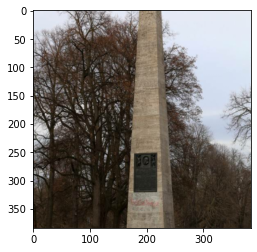

In [26]:
image1 = imported.extract_image(
        path = '../input/train',
        image_id=train_df.id[0],
        dim=384, 
        central_crop=True, 
        crop_ratio=(0.7, 1.0))

plt.figure(figsize=(4, 4))
plt.imshow(image1[0])

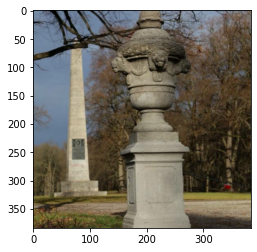

In [27]:
image2 = imported.extract_image(
        path = '../input/train',
        image_id=train_dataframe[train_dataframe.id == '92b6290d571448f6'].id.values[0],
        dim=384, 
        central_crop=True, 
        crop_ratio=(0.7, 1.0))

plt.figure(figsize=(4, 4))
plt.imshow(image2[0])

local score  = 0.15714285714285714


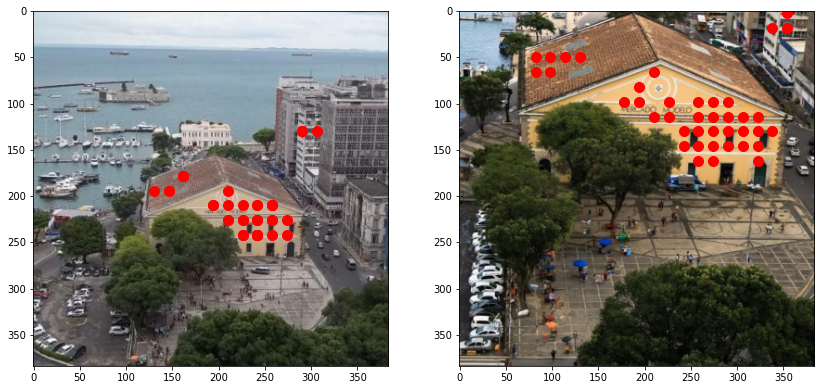

In [76]:
max_inlier_score = 70

train_image = imported.extract_image(
        train_df.path[39],
        dim=384, 
        central_crop=True, 
        crop_ratio=(0.7, 1.0))
train_global_descriptor, (train_local_descriptor, train_keypoints) = imported.extract_global_and_local_descriptor(
    image=train_image,
    l2_norm=True,
    attention_threshold=175.0,
    nms_max_feature_num=1000,
    nms_iou_threshold=1.0)


test_image = imported.extract_image(
        train_df.path[44],
        dim=384, 
        central_crop=True, 
        crop_ratio=(0.7, 1.0))
test_global_descriptor, (test_local_descriptor, test_keypoints) = imported.extract_global_and_local_descriptor(
    image=test_image,
    l2_norm=True,
    attention_threshold=175.0,
    nms_max_feature_num=1000,
    nms_iou_threshold=1.0)

train_match_kp, test_match_kp, mask, num_inliers = compute_num_inliers(
    test_keypoints, 
    test_local_descriptor, 
    train_keypoints, 
    train_local_descriptor)

local_score = min(num_inliers, max_inlier_score) / max_inlier_score
print('local score  =', local_score)
#print('global score =', global_score)
#print('combined     =', local_score + global_score)

fig, axes = plt.subplots(1, 2, figsize=(14, 14))

axes[0].imshow(train_image[0])
axes[0].scatter(train_match_kp[:, 1], train_match_kp[:, 0], s=100, c='red')
axes[1].imshow(test_image[0])
axes[1].scatter(test_match_kp[:, 1], test_match_kp[:, 0], s=100, c='red')

label1, label2 = 1, 1
tf.Tensor(
[[  2. 194.]
 [  2. 210.]
 [ 18. 194.]
 [ 18. 210.]
 [338. 194.]
 [ 98. 194.]
 [338. 210.]
 [ 34. 194.]
 [ 50. 194.]
 [ 82. 194.]
 [ 34. 210.]
 [ 66. 194.]
 [130. 194.]
 [162. 210.]
 [194. 194.]
 [178. 306.]
 [146. 194.]
 [274. 194.]
 [242. 322.]
 [146. 210.]
 [194. 210.]
 [258. 178.]
 [258. 162.]
 [ 82. 210.]
 [114. 194.]
 [338. 178.]
 [210. 210.]
 [162. 194.]
 [194. 306.]
 [242. 338.]
 [ 66. 210.]
 [130. 210.]
 [ 98. 210.]
 [274.  50.]
 [226. 210.]
 [226. 194.]
 [258. 194.]
 [ 18. 226.]
 [ 50. 210.]
 [178. 322.]
 [ 82. 178.]
 [178. 194.]
 [210. 194.]
 [354. 194.]], shape=(44, 2), dtype=float32)
44
44


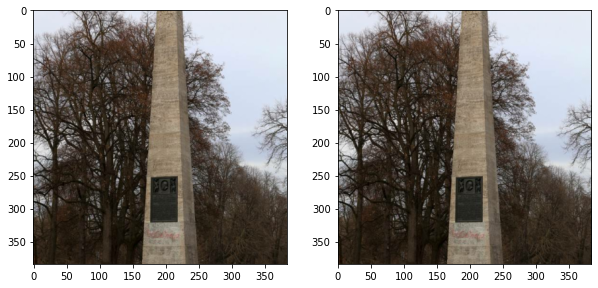

In [34]:
def _compute_matching_keypoints(test_keypoints, 
                                test_descriptors, 
                                train_keypoints, 
                                train_descriptors,
                                max_distance=0.9):
    
    '''
    Finds matches from 'test_descriptors' to the KD-tree of 'train_descriptors'. 
    Functions as a fast nearest neighbour search.
    '''
    
    train_descriptor_tree = scipy.spatial.cKDTree(train_descriptors)
    _, matches = train_descriptor_tree.query(test_descriptors, distance_upper_bound=max_distance)
    
    test_kp_count = test_keypoints.shape[0]
    train_kp_count = train_keypoints.shape[0]

    test_matching_keypoints = np.array([
        test_keypoints[i,]
        for i in range(test_kp_count)
        if matches[i] != train_kp_count
    ])

    train_matching_keypoints = np.array([
        train_keypoints[matches[i],]
        for i in range(test_kp_count)
        if matches[i] != train_kp_count
    ])
    return test_matching_keypoints, train_matching_keypoints

def compute_num_inliers(test_keypoints, 
                        test_descriptors, 
                        train_keypoints, 
                        train_descriptors,
                        max_reprojection_error=4.0,
                        homography_confidence=0.99,
                        max_ransac_iterations=1000):
    
    '''
    Out of the matches descriptor keypoints, runs a RANSAC to computes the
    number of inliers.
    '''
    test_match_kp, train_match_kp = _compute_matching_keypoints(
        test_keypoints, test_descriptors, train_keypoints, train_descriptors)
    
    # Min keypoints supported by `pydegensac.findHomography()`
    if test_match_kp.shape[0] <= 4:  
        return 0

    try:
        _, mask = pydegensac.findHomography(
            test_match_kp, train_match_kp, 
            max_reprojection_error,
            homography_confidence, 
            max_ransac_iterations
        )
    except np.linalg.LinAlgError:  # When det(H)=0, can't invert matrix.
        return 0
    
    return int(copy.deepcopy(mask).astype(np.float32).sum())

idx1, idx2 = 0, 0
path1, path2 = train_df.path[idx1], train_df.path[idx2]
print('label1, label2 = {}, {}'.format(train_df.iloc[idx1].landmark_id, train_df.iloc[idx2].landmark_id))


image1 = imported.extract_image(
    path1, 
    dim=384, 
    central_crop=True, 
    crop_ratio=(0.7, 1.0)
)
train_descriptors, train_keypoints = imported.extract_local_descriptor(
    image1, l2_norm=True, attention_threshold=175.0, nms_max_feature_num=1000, nms_iou_threshold=1.0)
#train_descriptors = tf.nn.l2_normalize(train_descriptors, axis=1)


image2 = imported.extract_image(
    path2, 
    dim=384, 
    central_crop=True, 
    crop_ratio=(0.7, 1.0)
)
test_descriptors, test_keypoints = imported.extract_local_descriptor(
    image2, l2_norm=True, attention_threshold=175.0, nms_max_feature_num=1000, nms_iou_threshold=1.0)
#test_descriptors = tf.nn.l2_normalize(test_descriptors, axis=1)
print(test_keypoints)
print(len(train_keypoints))
print(len(test_keypoints))

fig, axes = plt.subplots(1, 2, figsize=(10, 10))

axes[0].imshow(image1[0])
axes[1].imshow(image2[0])

In [33]:
# test_match_kp, train_match_kp = compute_matching_keypoints(
#     test_keypoints, test_descriptors, train_keypoints, train_descriptors)

max_inlier_score = 70

num_inliers = compute_num_inliers(
    test_keypoints, 
    test_descriptors, 
    train_keypoints, 
    train_descriptors)

local_score = min(num_inliers, max_inlier_score) / max_inlier_score
print('local score  =', local_score)
#print('global score =', global_score)
#print('combined     =', local_score + global_score)

local score  = 0.6285714285714286


local score  = 0.08571428571428572
